Functions

In [2]:
#Function to test for stationarity
def adfuller_test(series, sig=0.05, name=''):
    res = adfuller(series, autolag='AIC')
    p_value = round(res[1], 3)

    if p_value <= sig:
        print(f" {name} : P-Value = {p_value} => Stationary. ")
    else:
        print(f" {name} : P-Value = {p_value} => Non-stationary.")

In [3]:
#Function to split dataset based on date selected
def train_test_split(df, enddate_train,startdate_test):
    df_train = df[:enddate_train]
    df_test = df[startdate_test:]
    return df_train, df_test

In [4]:
#Function extract X and Y from dataset
#ADJUST: which X variables we want
def X_Y_transform(df):
    #X = df[['Corn Price Futures','OIL_PRICE $/bbl','OBS_VALUE_QUANTITY_TON']]
    X = df[[ 'AVG_TAVG',
             'Corn Price Futures', #MAIZE DATA SET
             #'Sunflower Seed Price Futures', #SUNFLOWER DATASET
             #'Wheat Price Futures', #Wheat DATASET
            'OBS_VALUE_QUANTITY_TON',
            'OIL_PRICE $/bbl',
            'unemployment_total']]
    Y = df['price']
    return X, Y

In [5]:
#Function ARIMAX multi step forecast
def arimax_forecast(history, future, config, step_size):
    order, trend = config
    # define model
    X_train,Y_train = X_Y_transform(history)
    #X_test,Y_test = X_Y_transform(future)
    model = ARIMA(endog = Y_train, order=order, trend=trend, enforce_stationarity=False, enforce_invertibility=False)
    # fit model
    model_fit = model.fit()
    # multistep forecast
    y_hat = model_fit.predict(len(history), (len(history)+step_size-1))
    return y_hat

In [6]:
#Function Moving window for univariate data
def moving_window(df, step, cfg):
    print("Fitting the combination", cfg)
    predictions = []
    history_size, step_size = step
    history = df[:history_size]
    future = df[history_size:(history_size+step_size)]

    # step over each time-step in the test set
    for i in range(int(math.ceil((len(df)-history_size)/6))):
        # fit model and make forecast for history
        if len(future) < step_size:
            step_size = len(future)

        yhat = arimax_forecast(history, future, cfg, step_size)
        # store forecast in list of predictions
        if i == 0:
            predictions = yhat
        else:
            predictions = predictions.append(yhat)
        # move the history and forecast window
        history = history.append(future)
        history = history[step_size:]
        future = df[(history_size+(step_size*(i+1))):(history_size+(step_size*(i+2)))]

    # estimate prediction error
    future = df[history_size:]
    X_test,Y_test = X_Y_transform(future)
    score = evaluation_measures(Y_test, predictions)
    #print(predictions)
    print(score)
    return score, predictions

In [7]:
#Function performance measures
def evaluation_measures(actual, predicted):
    mse = np.square(np.subtract(actual, predicted)).mean()
    return mse

In [8]:
#Function to  create a set of arimax configs to try
def arima_config(p,d,q):
    models = list()
    # define config lists
    p_params = list(range(1,p))
    d_params = list(range(1,d))
    q_params = list(range(1,q))
    t_params = ['n']
    # create config instances
    for p in p_params:
        for d in d_params:
            for q in q_params:
                for t in t_params:
                    cfg = [(p,d,q), t]
                    models.append(cfg)
    return models

In [9]:
#Function run grid search configs
def grid_search(df, cfg_list, step):
    scores = list()
    filterwarnings("ignore")
    best_score = np.inf
    best_prediction = list()
    best_cfg = list()

    for cfg in cfg_list:
        score, prediction = moving_window(df, step, cfg)
        scores.append(score)

        if score < best_score:
            print("Found an improved score", score,"is better than", best_score )
            best_score = score
            best_cfg = cfg
            best_prediction = prediction

    return best_cfg, best_score, best_prediction

In [10]:
#Function take log of price and standardize
def transform_data(df):
    df['price'] = np.log(df['price'])
    col_list = df.columns
    #mean_list = []
    #sd_list = []
    mean_p = 0
    sd_p = 0

    for col in col_list:
        if col == 'price':
            mean_p = st.mean(df[col])
            sd_p = st.pstdev(df[col])
            df[col] = (df[col]-mean_p)/sd_p
        else:
            mean = st.mean(df[col])
            sd = st.pstdev(df[col])
            df[col] = (df[col]-mean)/sd

    if mean_p == 0:
        print("Warning: price variable not found")
    return df, mean_p, sd_p

In [17]:
#Function take log of price and standardize test set
def transform_data_test(df,mean_list, sd_list):
    df = np.log(df)
    col_list = df.columns

    for i in range(len(col_list)):
        col = col_list[i]
        df[col] = (df[col]-mean_list[i])/sd_list[i]

    return df

In [12]:
#Function take log of price and standardize train set
def transform_data_train(df):
    df = np.log(df)
    col_list = df.columns
    mean_list = []
    sd_list = []
    mean = 0
    sd = 0

    for col in col_list:
        mean = st.mean(df[col])
        sd = st.pstdev(df[col])
        df[col] = (df[col]-mean)/sd
        mean_list.append(mean)
        sd_list.append(sd)

    return df, mean_list, sd_list

Main code

In [58]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller
import numpy as np
from warnings import filterwarnings
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
import math
import statistics as st
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from datetime import datetime

Pre examination of model

In [14]:
df_maize = pd.read_excel('MAIZE_FILTERED_2023-02-25_19-36-41.xlsx', header=[0, 1], index_col=0) #ADJUST to product
#df_sunflower = pd.read_excel('SUNFLOWER_FILTERED_2023-02-26_22-04-41.xlsx', header=[0, 1], index_col=0) #ADJUST to product
#df_wheat = pd.read_excel('WHEAT_FILTERED_2023-03-03_02-44-24.xlsx', header=[0, 1], index_col=0) #ADJUST to product

variable_list = list(df_maize.columns.levels[0])
country_list = list(df_maize.columns.levels[1])

print(country_list)
print(variable_list)


['Brazil', 'France', 'Germany', 'Hungary', 'Ukraine']
['AVG_TAVG', 'Corn Price Futures', 'MAX_TMAX', 'MIN_TMIN', 'OBS_VALUE_QUANTITY_TON', 'OBS_VALUE_VALUE_1000EURO', 'OIL_PRICE $/bbl', 'agricultural_land', 'energy_use_kg_of_oil_equivalent_per_capita', 'fossil_fuel_energy_consumption_perc_of_total', 'gdp_current_us', 'globalprice', 'population_projections', 'population_total', 'price', 'renewable_energy_consumption_perc_of_total', 'unemployment_total']


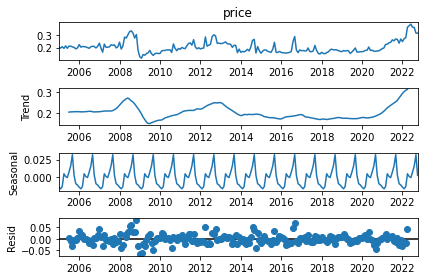

  : P-Value = 0.0 => Stationary. 


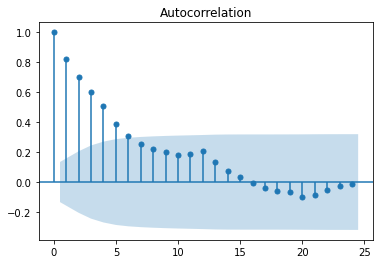

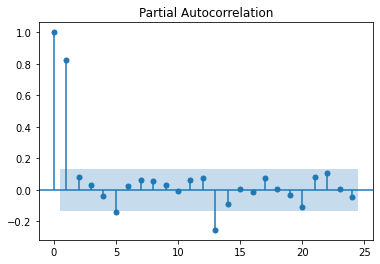

,AVG_TAVG,Corn Price Futures,MAX_TMAX,MIN_TMIN,OBS_VALUE_QUANTITY_TON,OBS_VALUE_VALUE_1000EURO,OIL_PRICE $/bbl,agricultural_land,energy_use_kg_of_oil_equivalent_per_capita,fossil_fuel_energy_consumption_perc_of_total,gdp_current_us,globalprice,population_projections,population_total,price,renewable_energy_consumption_perc_of_total,unemployment_total
TIME_PERIOD,,,,,,,,,,,,,,,,,
2005-01-01,0.869290,204.50,102.142857,-105.930233,1890.6,0.080000,42.972278,413040.000000,3033.1800,83.280000,8.923937e+10,0.122419,44831135.00,47105171.00,0.203184,1.27,7.180000
2005-02-01,-38.376438,222.75,60.142857,-190.275862,1890.6,0.080000,44.818211,413023.333333,3025.0225,83.173333,9.112649e+10,0.118578,44813750.25,47078722.25,0.196810,1.31,7.149167
2005-03-01,-3.794989,221.00,112.468208,-123.523810,1890.6,0.080000,50.942879,413006.666667,3016.8650,83.066667,9.301360e+10,0.121397,44796365.50,47052273.50,0.208014,1.35,7.118333
2005-04-01,90.622214,213.50,204.189944,-37.809524,1890.6,0.080000,50.640476,412990.000000,3008.7075,82.960000,9.490072e+10,0.116070,44778980.75,47025824.75,0.194268,1.39,7.087500
2005-05-01,161.493475,230.75,307.400000,57.571429,1890.6,0.085714,47.826573,412973.333333,3000.5500,82.853333,9.678783e+10,0.122371,44761596.00,46999376.00,0.214214,1.43,7.056667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06-01,209.451222,743.75,323.350000,107.608696,24462.7,9377.970000,116.800000,413110.000000,2334.4000,75.350000,2.000855e+11,0.362607,45163879.25,43792855.00,0.383358,7.44,9.830000
2022-07-01,212.861598,616.25,327.692308,111.333333,2732.8,981.840000,105.083333,413110.000000,2334.4000,75.350000,2.000855e+11,0.403995,45163879.25,43792855.00,0.359280,7.44,9.830000
2022-08-01,224.523306,673.75,313.440000,158.523810,6780.1,2425.380000,95.973333,413110.000000,2334.4000,75.350000,2.000855e+11,0.254172,45163879.25,43792855.00,0.357720,7.44,9.830000


In [15]:
country = 'Ukraine'
df = df_maize.xs(country, axis = 1, level =1 , drop_level=True) #ADJUST to country

#Stationairity
decom = sm.tsa.seasonal_decompose(df.price, model='additive')
decom.plot()
plt.show()

price_diff = df.price.diff()
price_diff[0] = 0
adfuller_test(price_diff) #Chose the max d order

#ACF/PCF
plot_acf(df.price) #Chose the max p order
plt.show()

plot_pacf(df.price) #Chose the max q order
plt.show()

df

Main code

In [18]:
if __name__ == '__main__':
    #Import data of the required product
    df_maize = pd.read_excel('MAIZE_FILTERED_2023-02-25_19-36-41.xlsx', header=[0, 1], index_col=0) #ADJUST to product
    #df_wheat = pd.read_excel('WHEAT_FILTERED_2023-03-03_02-44-24.xlsx', header=[0, 1], index_col=0) #ADJUST to product
    #df_sunflower = pd.read_excel('SUNFLOWER_FILTERED_2023-02-26_22-04-41.xlsx', header=[0, 1], index_col=0) #ADJUST to product

    #Select which country dataset you want to forcast
    product = 'Maize'
    country = 'Ukraine'
    df = df_maize.xs(country, axis = 1, level =1 , drop_level=True) #ADJUST to country

    #split the data in test and train
    enddate_train = "2022-04-01"
    startdate_test = "2019-11-01"

    #df_train, df_test = train_test_split(df, enddate_train,startdate_test )
    df_train_unedited, df_test_unedited = train_test_split(df, enddate_train,startdate_test )

    #take log price and standardize the data
    df_train = df_train_unedited.copy()
    df_train, mean_list, sd_list = transform_data_train(df_train)

    # model configs
    p = 7
    d = 2
    q = 4
    cfg_list = arima_config(p,d, q)
    step = [24,6] #history horizon and multistepforecast

    # grid search on train dataset with minimum MSE
    best_cfg, lowest_score, predictions_train = grid_search(df_train, cfg_list,step)
    print('Gridsearch found with best parameters', best_cfg, "with MSE equal to", lowest_score)


Fitting the combination [(1, 1, 1), 'n']
0.7750896826109301
Found an improved score 0.7750896826109301 is better than inf
Fitting the combination [(1, 1, 2), 'n']
0.6764250163308793
Found an improved score 0.6764250163308793 is better than 0.7750896826109301
Fitting the combination [(1, 1, 3), 'n']
0.8252888738469757
Fitting the combination [(2, 1, 1), 'n']
0.7526302903444916
Fitting the combination [(2, 1, 2), 'n']
0.6886116380860837
Fitting the combination [(2, 1, 3), 'n']
0.8031020074193008
Fitting the combination [(3, 1, 1), 'n']
0.6753834946759888
Found an improved score 0.6753834946759888 is better than 0.6764250163308793
Fitting the combination [(3, 1, 2), 'n']
0.6703692263109062
Found an improved score 0.6703692263109062 is better than 0.6753834946759888
Fitting the combination [(3, 1, 3), 'n']
0.7532356022177086
Fitting the combination [(4, 1, 1), 'n']
0.7023503008294459
Fitting the combination [(4, 1, 2), 'n']
1.3324221628854367e+52
Fitting the combination [(4, 1, 3), 'n']
0.

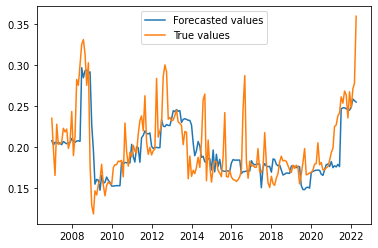

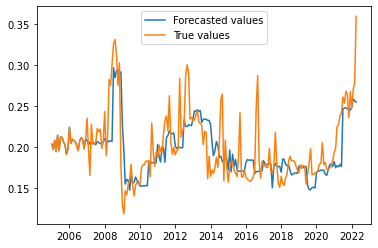

In [27]:
#Visulaize the train results
predictions_train_destandardize = np.exp(predictions_train*sd_list[df.columns.get_loc("price")]+mean_list[df.columns.get_loc("price")])

#plot only forcast horizon
plt.plot(predictions_train_destandardize,label='Forecasted values')
plt.plot(df_train_unedited.price[step[0]:],label='True values')
plt.legend()
plt.show()

#plot on full period
trueprices = df_train_unedited.price
forecasted_prices = trueprices[:len(trueprices)-len(predictions_train_destandardize)]
forecasted_prices = forecasted_prices.append(predictions_train_destandardize)


plt.plot(forecasted_prices,label='Forecasted values')
plt.plot(trueprices,label='True values')
plt.legend()
plt.show()

Post fit evaluation

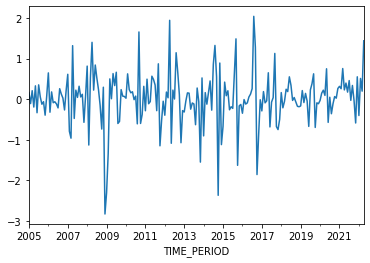

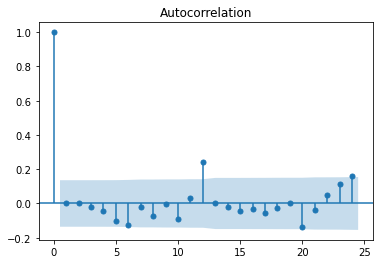

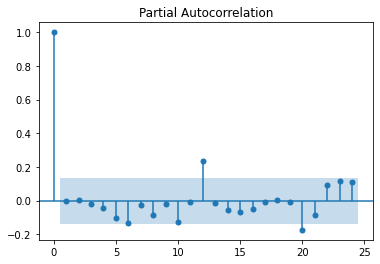

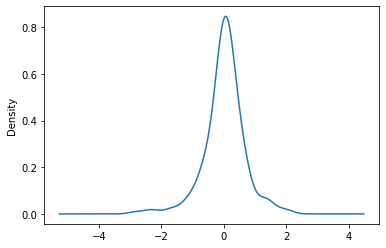

count    208.000000
mean       0.018906
std        0.650945
min       -2.830639
25%       -0.216918
50%        0.046787
75%        0.301306
max        2.043901
dtype: float64


In [25]:
#Fit on full model
order_b, trend_b = best_cfg
# define model
X_train, Y_train = X_Y_transform(df_train)

model_b = ARIMA(endog = Y_train, order=order_b, trend=trend_b, enforce_stationarity=False, enforce_invertibility=False)
# fit model
model_fit_b = model_b.fit()

# Print the model summary
#print(model_fit_b.summary())

# line plot of residuals
residuals = model_fit_b.resid
residuals.plot()
plt.show()

#ACF/PCF
plot_acf(residuals) #Chose the max p order
plt.show()

plot_pacf(residuals) #Chose the max q order
plt.show()

# density plot of residuals
residuals.plot(kind='kde')
plt.show()

# summary stats of residuals
print(residuals.describe())


Evaluation on Test

Fitting the combination [(3, 1, 2), 'n']
1.3879106382743398
For Ukraine with orders [(3, 1, 2), 'n'] we find MSE: 1.3879106382743398 MAE: 0.8247154105187127 MAPE: 1.2291182918236518


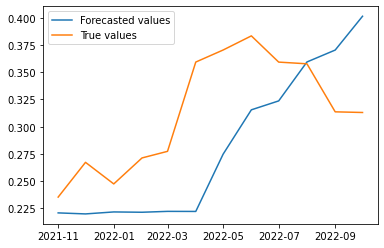

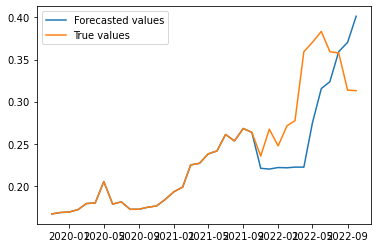

In [26]:
#Run test set
df_test = df_test_unedited.copy()
df_test, mean_tp, sd_tp = transform_data(df_test)

score_test, predictions_test = moving_window(df_test, step, best_cfg)

predictions_test_destandardize = np.exp(predictions_test*sd_list[df.columns.get_loc("price")]+mean_list[df.columns.get_loc("price")])

#measures MSE, MAE,MAPE
#MSE = mean_squared_error(df_test_unedited.price[step[0]:], predictions_test_destandardize)
#MAE = mean_absolute_error(df_test_unedited.price[step[0]:], predictions_test_destandardize)
#MAPE = mean_absolute_percentage_error(df_test_unedited.price[step[0]:], predictions_test_destandardize)

MSE = mean_squared_error(df_test.price[step[0]:], predictions_test)
MAE = mean_absolute_error(df_test.price[step[0]:], predictions_test)
MAPE = mean_absolute_percentage_error(df_test.price[step[0]:], predictions_test)

print("For",country,"with orders",best_cfg,"we find MSE:", MSE,"MAE:",MAE,"MAPE:",MAPE)
#Visulaize the test results

#plot only forcast horizon
plt.plot(predictions_test_destandardize,label='Forecasted values')
plt.plot(df_test_unedited.price[step[0]:],label='True values')
plt.legend()
plt.show()

#plot on full period
trueprices_t = df_test_unedited.price
forecasted_pricest = trueprices_t[:len(trueprices_t)-len(predictions_test_destandardize)]
forecasted_pricest = forecasted_pricest.append(predictions_test_destandardize)


plt.plot(forecasted_pricest,label='Forecasted values')
plt.plot(trueprices_t,label='True values')
plt.legend()
plt.show()

In [59]:
#Export Forecasts
destand_pred = pd.DataFrame(predictions_test_destandardize)
destand_pred.rename(columns={'predicted_mean': 'Predictions',}, inplace=True)

stand_pred = pd.DataFrame(predictions_test)
stand_pred.rename(columns={'predicted_mean': 'Standerdized Predictions',}, inplace=True)

export = pd.concat([stand_pred,destand_pred], axis = 1)
export = pd.concat([export,df_test_unedited.price[step[0]:]], axis = 1)

# get the current date and time
now = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
product = 'Maize'
country = 'Ukraine'

# save the DataFrame to an Excel file with the current timestamp in the file name
filename = f'PriceForecast_{product}_{country}_{now}.xlsx'
export.to_excel(filename, index=True)